## Day 48 Lecture 1 Assignment

In this assignment, we will apply hierarchical clustering to a dataset containing the locations of all Starbucks in the U.S.

Note: this assignment uses geographical data and maps, which will require the use of two specific packages: haversine and plotly. Both of these can be pip installed.

In [1]:
!pip install haversine
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from haversine import haversine
import plotly.express as px
from sklearn.preprocessing import StandardScaler

Below are some convenience functions for calculating geographical distance matrices using lat-long data and plotting a dendrogram by combining a scikit-learn model with scipy's dendrogram plotting functionality.

In [3]:
def geo_sim_matrix(df, col_name = 'Coordinates'):
    """
    A function that computes a geographical distance matrix (in miles).
    Each row in the dataframe should correspond to one location.
    In addition, the dataframe must have a column containing the lat-long of each location as a tuple (i.e. (lat, long)).
    
    Parameters:
        df (pandas dataframe): an nxm dataframe containing the locations to compute similarities between.
        col (string): the name of the column containing the lat-long tuples.
        
    Returns:
        distance (pandas dataframe): an nxn distance matrix between the geographical coordinates of each location.
    """
    
    df = df.copy()
    df.reset_index(inplace=True)
    haver_vec = np.vectorize(haversine, otypes=[np.float32])
    distance = df.groupby('index').apply(lambda x: pd.Series(haver_vec(df[col_name], x[col_name])))
    distance = distance / 1.609344
    distance.columns = distance.index
    
    return distance


def plot_dendrogram(model, **kwargs):
    """
    A basic function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
    
    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.
    
    Output: a dendrogram based on the model based in the parameters.
    
    Returns: N/A    
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

This dataset contains the latitude and longitude (as well as several other details we will not be using) of every Starbucks in the world as of February 2017. Each row consists of the following features, which are generally self-explanatory:

- Brand
- Store Number
- Store Name
- Ownership Type
- Street Address
- City
- State/Province
- Country
- Postcode
- Phone Number
- Timezone
- Longitude
- Latitude

Load in the dataset.

In [4]:
# answer goes here
url = 'https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/starbucks_locations.csv'

starbucks_df = pd.read_csv(url)


Begin by narrowing down the dataset to a specific geographic area of interest. Since we will need to manually compute a distance matrix, which will be on the order of $n^{2}$ in terms of size, we would recommend choosing an area with 3000 or less locations. In this example, we will use California, which has about 2800 locations. Feel free to choose a different region that is of more interest to you, if desired.

Subset the dataframe to only include records for Starbucks locations in California.

In [5]:
# answer goes here
ca_starbucks = starbucks_df.loc[(starbucks_df['Country']=='US')&(starbucks_df['State/Province']=='CA')]

ca_starbucks.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
12641,Starbucks,10429-100710,Palmdale & Hwy 395,Company Owned,14136 US Hwy 395,Adelanto,CA,US,923016700,760-530-9252,GMT-08:00 America/Los_Angeles,-117.40,34.51
12642,Starbucks,635-352,Kanan & Thousand Oaks,Company Owned,5827 Kanan Road,Agoura,CA,US,913011651,(818) 735-0268,GMT-08:00 America/Los_Angeles,-118.76,34.16
12643,Starbucks,74510-27669,Vons-Agoura Hills #2001,Licensed,5671 Kanan Rd.,Agoura Hills,CA,US,913013358,818-991-2857,GMT-08:00 America/Los_Angeles,-118.76,34.15
12644,Starbucks,29839-255026,Target Anaheim T-0677,Licensed,8148 E SANTA ANA CANYON ROAD,AHAHEIM,CA,US,92808,714-921-9091,GMT-08:00 America/Los_Angeles,-117.75,33.87
12645,Starbucks,23463-230284,Safeway - Alameda 3281,Licensed,2600 5th Street,Alameda,CA,US,94501,510-523-1804,GMT-08:00 America/Los_Angeles,-122.28,37.79


The haversine package takes tuples with 2 numeric elements and interprets them as lat-long to calculate distance, so add a new column called "Coordinates" that converts the lat and long in each row into a tuple. In other words, the last two columns of the dataframe should initially look like this:

**Latitude, Longitude**  
-121.64, 39.14  
-116.40, 34.13  
...

After adding the new column, the last three columns should look like this:

**Latitude, Longitude, Coordinates**  
-121.64, 39.14, (-121.64, 39.14)  
-116.40, 34.13, (-116.40, 34.13)  
...

In [6]:
# answer goes here
ca_starbucks = pd.concat([ca_starbucks, pd.Series(tuple(zip(ca_starbucks['Latitude'],ca_starbucks['Longitude'])),index=ca_starbucks.index, name='Coordinates')],1)
ca_starbucks.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude,Coordinates
12641,Starbucks,10429-100710,Palmdale & Hwy 395,Company Owned,14136 US Hwy 395,Adelanto,CA,US,923016700,760-530-9252,GMT-08:00 America/Los_Angeles,-117.40,34.51,"(34.51, -117.4)"
12642,Starbucks,635-352,Kanan & Thousand Oaks,Company Owned,5827 Kanan Road,Agoura,CA,US,913011651,(818) 735-0268,GMT-08:00 America/Los_Angeles,-118.76,34.16,"(34.16, -118.76)"
12643,Starbucks,74510-27669,Vons-Agoura Hills #2001,Licensed,5671 Kanan Rd.,Agoura Hills,CA,US,913013358,818-991-2857,GMT-08:00 America/Los_Angeles,-118.76,34.15,"(34.15, -118.76)"
12644,Starbucks,29839-255026,Target Anaheim T-0677,Licensed,8148 E SANTA ANA CANYON ROAD,AHAHEIM,CA,US,92808,714-921-9091,GMT-08:00 America/Los_Angeles,-117.75,33.87,"(33.87, -117.75)"
12645,Starbucks,23463-230284,Safeway - Alameda 3281,Licensed,2600 5th Street,Alameda,CA,US,94501,510-523-1804,GMT-08:00 America/Los_Angeles,-122.28,37.79,"(37.79, -122.28)"


Calculate the distance matrix using the starter code/function geo_sim_matrix() provided earlier in the notebook. It assumes the column containing the coordinates for each location is called "Coordinates"; examine the docstring for more details.

In [7]:
# answer goes here
ca_distance = geo_sim_matrix(ca_starbucks, col_name = 'Coordinates')
ca_distance

index,12641,12642,12643,12644,12645,12646,12647,12648,12649,12650,12651,12652,12653,12654,12655,12656,12657,12658,12659,12660,12661,12662,12663,12664,12665,12666,12667,12668,12669,12670,12671,12672,12673,12674,12675,12676,12677,12678,12679,12680,...,15422,15423,15424,15425,15426,15427,15428,15429,15430,15431,15432,15433,15434,15435,15436,15437,15438,15439,15440,15441,15442,15443,15444,15445,15446,15447,15448,15449,15450,15451,15452,15453,15454,15455,15456,15457,15458,15459,15460,15461
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12641,0.000000,81.273884,81.486523,48.533654,354.143237,351.144203,353.715324,351.573102,351.144810,353.715324,351.573102,346.220527,346.220527,359.302962,51.245597,52.109962,51.176217,51.717049,50.251053,50.776189,67.329190,67.329190,67.640051,66.152874,121.945225,369.772141,370.231874,53.515812,56.771924,54.432850,48.771988,56.282211,57.426285,54.707194,52.077080,55.905246,56.771924,57.362594,48.934712,55.639938,...,51.597697,52.073619,51.837358,52.336747,63.538575,63.538575,64.143306,471.026670,436.551150,65.555723,410.299052,409.892718,409.892718,408.168967,375.718023,377.502683,374.487341,374.132245,71.839298,71.300410,72.153516,73.458825,70.762020,72.918515,71.934292,72.153516,74.225759,73.147903,48.027439,49.385124,572.658899,395.987034,396.757074,397.082816,393.690722,396.534678,36.817172,37.543912,38.428927,62.814312
12642,81.273884,0.000000,0.690934,61.215416,318.757960,315.771480,318.222604,316.116109,315.964748,318.222604,316.116109,313.648335,313.648335,324.623327,35.790141,35.327049,36.457392,35.223510,37.588560,36.356939,72.736563,72.736563,71.789165,71.485894,147.837173,338.553510,339.111735,54.239544,53.858583,52.665262,60.674551,50.879654,51.499973,53.473606,56.881879,52.730242,53.858583,54.174838,61.987702,51.913830,...,41.556237,41.747618,46.627519,44.011144,95.388196,95.388196,95.152688,442.117360,417.107132,101.987866,378.112904,377.781207,377.781207,376.026850,353.734855,355.047798,352.608923,352.349248,9.743349,10.313685,9.250381,8.033502,10.884163,8.603220,9.377984,9.250381,7.432479,8.575938,59.138057,56.428305,562.278769,378.637148,379.649493,379.881635,376.304313,379.259277,94.263582,97.044544,97.681408,134.964978
12643,81.486523,0.690934,0.000000,60.995993,319.309283,316.323315,318.773358,316.667394,316.517721,318.773358,316.667394,314.216725,314.216725,325.178063,35.705420,35.227597,36.361163,35.137353,37.495368,36.273610,72.354544,72.354544,71.401970,71.110531,147.414020,339.126033,339.684714,53.973146,53.554463,52.390667,60.453100,50.585684,51.190918,53.194280,56.628219,52.437728,53.554463,53.863641,61.763359,51.625871,...,41.380083,41.560793,46.409348,43.801473,95.114744,95.114744,94.873462,442.692348,417.727251,101.728181,378.675642,378.344401,378.344401,376.590082,354.349817,355.660636,353.224416,352.965157,9.817139,10.383488,9.379041,8.122617,10.950396,8.686557,9.555010,9.379041,7.464964,8.604232,58.926907,56.206644,562.924033,379.268000,380.281142,380.512980,376.935241,379.890358,94.205783,96.993658,97.626027,134.964125
12644,48.533654,61.215416,60.995993,0.000000,371.048068,368.038567,370.555416,368.421273,368.150523,370.555416,368.421273,364.680644,364.680644,376.644732,27.024946,27.125906,26.164851,27.500556,25.219250,26.553179,20.855105,20.855105,20.759869,19.422810,92.164596,389.129272,389.646310,8.150535,10.600335,9.851198,0.573686,12.226497,12.536326,9.411672,5.345477,10.692122,10.600335,10.889642,0.898078,11.097242,...,19.911708,19.610672,14.587899,17.216923,34.738242,34.738242,34.637440,492.103987,462.424183,41.046338,429.318039,428.951944,428.951944,427.203200,400.012256,401.567391,398.827502,398.518637,52.380261,51.854837,53.178531,53.962309,51.330417,53.434030,53.457947,53.178531,54.235197,53.172510,2.207012,4.792493,603.279255,422.692873,423.584388,423.866554,420.366600,423.279543,37.762600,40.703236,41.063149,79.387921
12645,354.143237,318.757960,319.309283,371.048068,0.000000,3.011417,0.690934,2.642126,3.060228

In [8]:
scaler = StandardScaler()
ca_dist_std = scaler.fit_transform(ca_distance)
ca_dist_std

array([[-1.33701522, -0.66089188, -0.6587077 , ..., -1.01462773,
        -1.0101544 , -1.05766913],
       [-0.74292545, -1.29283929, -1.2853628 , ..., -0.63287683,
        -0.63076934, -0.58281384],
       [-0.74137112, -1.28746691, -1.29072173, ..., -0.63320332,
        -0.63112394, -0.58281946],
       ...,
       [-1.06257953, -0.53826666, -0.53843349, ..., -1.25550622,
        -1.25046368, -1.21544943],
       [-1.05611031, -0.53331471, -0.5335288 , ..., -1.24974892,
        -1.25620927, -1.21837322],
       [-0.87785985, -0.24341524, -0.24393242, ..., -1.00630709,
        -1.01036177, -1.47107776]])

Build the hierarchical clustering model using n_clusters = 5 and average linkage. Bear in mind that we are passing a precomputed distance matrix, which will require an additional parameter to be manually specified. 

Additionally, save the predicted cluster assignments as a new column in your dataframe.

In [9]:
# answer goes here
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='precomputed',
                                      n_clusters=5)

clusters = agg_cluster.fit_predict(ca_distance)

agg_cluster_std = AgglomerativeClustering(linkage='average', 
                                      affinity='precomputed',
                                      n_clusters=5)

clusters_std = agg_cluster_std.fit_predict(ca_dist_std)

In [10]:
ca_starbucks = pd.concat([ca_starbucks, pd.Series(clusters, index=ca_starbucks.index, name='Cluster'),
                          pd.Series(clusters_std, index=ca_starbucks.index, name='Cluster_scaled')],1)
ca_starbucks

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude,Coordinates,Cluster,Cluster_scaled
12641,Starbucks,10429-100710,Palmdale & Hwy 395,Company Owned,14136 US Hwy 395,Adelanto,CA,US,923016700,760-530-9252,GMT-08:00 America/Los_Angeles,-117.40,34.51,"(34.51, -117.4)",0,4
12642,Starbucks,635-352,Kanan & Thousand Oaks,Company Owned,5827 Kanan Road,Agoura,CA,US,913011651,(818) 735-0268,GMT-08:00 America/Los_Angeles,-118.76,34.16,"(34.16, -118.76)",0,1
12643,Starbucks,74510-27669,Vons-Agoura Hills #2001,Licensed,5671 Kanan Rd.,Agoura Hills,CA,US,913013358,818-991-2857,GMT-08:00 America/Los_Angeles,-118.76,34.15,"(34.15, -118.76)",0,1
12644,Starbucks,29839-255026,Target Anaheim T-0677,Licensed,8148 E SANTA ANA CANYON ROAD,AHAHEIM,CA,US,92808,714-921-9091,GMT-08:00 America/Los_Angeles,-117.75,33.87,"(33.87, -117.75)",0,1
12645,Starbucks,23463-230284,Safeway - Alameda 3281,Licensed,2600 5th Street,Alameda,CA,US,94501,510-523-1804,GMT-08:00 America/Los_Angeles,-122.28,37.79,"(37.79, -122.28)",3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15457,Starbucks,14071-108147,Hwy 20 & Tharp - Yuba City,Company Owned,"1615 Colusa Hwy, Ste 100",Yuba City,CA,US,959939437,530-751-7187,GMT-08:00 America/Los_Angeles,-121.64,39.14,"(39.14, -121.64)",3,0
15458,Starbucks,9974-98559,"Yucaipa & Hampton, Yucaipa",Company Owned,"31364 Yucaipa Blvd., A",Yucaipa,CA,US,923991570,909-389-9587,GMT-08:00 America/Los_Angeles,-117.12,34.03,"(34.03, -117.12)",0,1
15459,Starbucks,79654-108478,Vons - Yucaipa #1796,Licensed,33644 YUCAIPA BLVD,YUCAIPA,CA,US,923992071,NaN,GMT-08:00 America/Los_Angeles,-117.07,34.04,"(34.04, -117.07)",0,1
15460,Starbucks,6438-245084,Yucaipa & 6th,Company Owned,"34050 Yucaipa Blvd., 200",Yucaipa,CA,US,92399,9097977224,GMT-08:00 America/Los_Angeles,-117.06,34.03,"(34.03, -117.06)",0,1


In [11]:
ca_starbucks['Cluster'].value_counts()

0    1566
3    1045
2     168
1      33
4       9
Name: Cluster, dtype: int64

In [12]:
ca_starbucks['Cluster_scaled'].value_counts()

1    1551
0    1065
3     182
4      13
2      10
Name: Cluster_scaled, dtype: int64

Plot the dendrogram using the provided starter code/function "plot_dendrogram". The dendrogram will be difficult to read because there are so many leaf nodes; try experimenting with smaller geographical areas for easier to read dendrograms.

In [13]:
random_dist = np.random.choice(ca_distance.index.tolist(), 500)

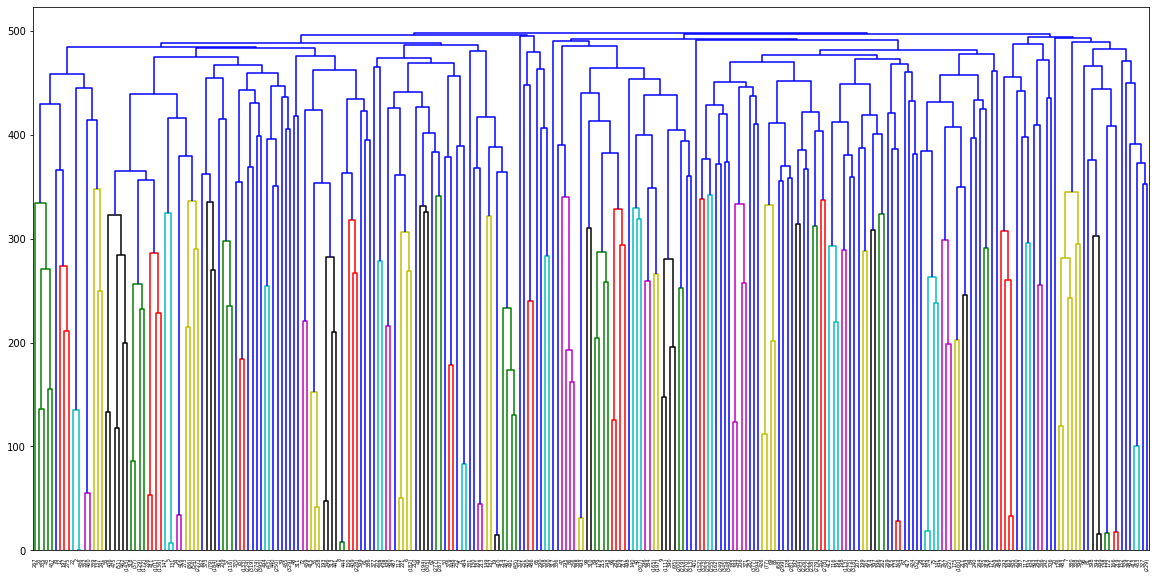

In [14]:
ca_sample = ca_distance.loc[random_dist,random_dist]

agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='precomputed',
                                      n_clusters=None,
                                      distance_threshold=0.3)

clusters_sample = agg_cluster.fit(ca_sample)
plt.figure(figsize=(20,10))
plot_dendrogram(clusters_sample, truncate_mode ='level', p=10)
plt.show()

Finally, plot the resulting clusters on a map using the "scatter_geo" function from plotly.express. The map defaults to the entire world; the "scope" parameter is useful for narrowing down the region plotted in the map. The documentation can be found here:

https://www.plotly.express/plotly_express/#plotly_express.scatter_geo

Tip: If the markers on the map are too large, their size can be changed with the following line of code:

*fig.update_traces(marker=dict(size=...)))*

Do the clusters correspond to geographic areas you would expect? Experiment with other values for n_cluster and linkage and see how they affect the results.

In [17]:
# answer goes here
fig = px.scatter_geo(data_frame=ca_starbucks, lat='Latitude', lon='Longitude', hover_name='Store Name', color='Cluster', color_continuous_scale='spectral')
fig.update_geos(scope='usa')
fig.update_geos(center_lon=ca_starbucks['Longitude'].mean())
fig.update_geos(center_lat=ca_starbucks['Latitude'].mean())
fig.show()

In [18]:
fig = px.scatter_geo(data_frame=ca_starbucks, lat='Latitude', lon='Longitude', hover_name='Store Name', color='Cluster_scaled', color_continuous_scale='spectral')
fig.update_geos(scope='usa')
fig.update_geos(center_lon=ca_starbucks['Longitude'].mean())
fig.update_geos(center_lat=ca_starbucks['Latitude'].mean())
fig.show()

In [19]:
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='precomputed',
                                      n_clusters=5)

clusters_com = agg_cluster.fit_predict(ca_distance)

agg_cluster_std = AgglomerativeClustering(linkage='complete', 
                                      affinity='precomputed',
                                      n_clusters=5)

clusters_std_com = agg_cluster_std.fit_predict(ca_dist_std)

ca_starbucks = pd.concat([ca_starbucks, pd.Series(clusters_com, index=ca_starbucks.index, name='Cluster_com'),
                          pd.Series(clusters_com, index=ca_starbucks.index, name='Cluster_scaled_com')],1)

In [20]:
fig = px.scatter_geo(data_frame=ca_starbucks, lat='Latitude', lon='Longitude', hover_name='Store Name', color='Cluster_com', color_continuous_scale='spectral')
fig.update_geos(scope='usa')
fig.update_geos(center_lon=ca_starbucks['Longitude'].mean())
fig.update_geos(center_lat=ca_starbucks['Latitude'].mean())
fig.show()

In [21]:
fig = px.scatter_geo(data_frame=ca_starbucks, lat='Latitude', lon='Longitude', hover_name='Store Name', color='Cluster_scaled_com', color_continuous_scale='spectral')
fig.update_geos(scope='usa')
fig.update_geos(center_lon=ca_starbucks['Longitude'].mean())
fig.update_geos(center_lat=ca_starbucks['Latitude'].mean())
fig.show()

In [22]:
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='precomputed',
                                      n_clusters=10)

clusters_ten = agg_cluster.fit_predict(ca_distance)

agg_cluster_std = AgglomerativeClustering(linkage='average', 
                                      affinity='precomputed',
                                      n_clusters=10)

clusters_std_ten = agg_cluster_std.fit_predict(ca_dist_std)

ca_starbucks = pd.concat([ca_starbucks, pd.Series(clusters_ten, index=ca_starbucks.index, name='Cluster_ten'),
                          pd.Series(clusters_std_ten, index=ca_starbucks.index, name='Cluster_scaled_ten')],1)

In [23]:
fig = px.scatter_geo(data_frame=ca_starbucks, lat='Latitude', lon='Longitude', hover_name='Store Name', color='Cluster_ten', color_continuous_scale='spectral')
fig.update_geos(scope='usa')
fig.update_geos(center_lon=ca_starbucks['Longitude'].mean())
fig.update_geos(center_lat=ca_starbucks['Latitude'].mean())
fig.show()

In [24]:
fig = px.scatter_geo(data_frame=ca_starbucks, lat='Latitude', lon='Longitude', hover_name='Store Name', color='Cluster_scaled_ten', color_continuous_scale='spectral')
fig.update_geos(scope='usa')
fig.update_geos(center_lon=ca_starbucks['Longitude'].mean())
fig.update_geos(center_lat=ca_starbucks['Latitude'].mean())
fig.show()